# Scaden 

## Group 5-fold cross-validation - results

## Quick analysis of MAGNet predictions at the end

In [110]:
import sys
import os
import numpy as np
import pandas as pd

from collections import defaultdict

from sklearn.metrics import mean_squared_error

import anndata


In [41]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

palette = sns.color_palette("tab10")

In [149]:
from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def annotate(data, **kws):
    r, p = stats.pearsonr(data['Simulated'], data['Predicted'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}'.format(r, p),
            transform=ax.transAxes)
    
def get_r(x, c, what='Pearson'):
    y = x[x.Cell==c]
    if what == 'Pearson':
        r, p = stats.pearsonr(y['Simulated'], y['Predicted'])
    elif what == 'Condordance':
        r = ccc(y['Simulated'], y['Predicted'])
    elif what == 'RMS':
        r = mean_squared_error(y['Simulated'], y['Predicted'], squared=False)
    return r


def ccc(y_true, y_pred):
    
    cor = np.corrcoef(y_true,y_pred)[0][1]
    
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    numerator = 2*cor*sd_true*sd_pred
    denominator = var_true + var_pred + (mean_true-mean_pred)**2

    return numerator/denominator


In [150]:
dirloc = '/prj/MAGE/analysis/deconvolution/scaden/kfold/results'

basename_predicted = 'predicted_bulk_100cells_1000samples_cell_composition.txt'
basename_true = 'test_bulk_100cells_1000samples_cell_composition.txt'

cell_types = ['Ventricular_cardiomyocyte', 'Endothelial', 'Smooth_muscle', 'Fibroblast', 'Pericyte', 'Immune', 'Unknown']
cols = cell_types + ['All']

correlations = {} #defaultdict(list)
cccs = {}
rmss = {}
cccs_per_sample = {}
rmss_per_sample = {}

num_samples = 1000
num_cells = len(cell_types)


True

True

True

True

True

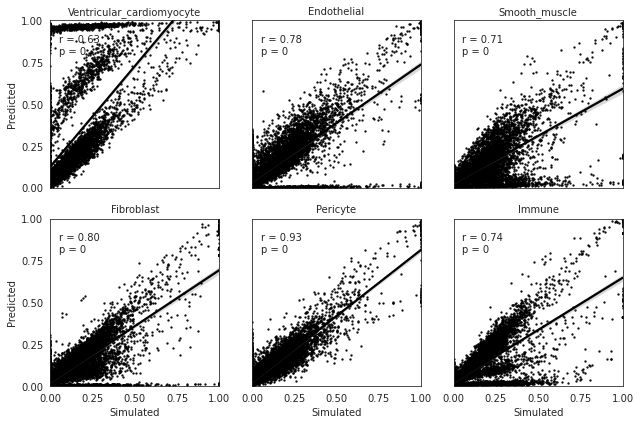

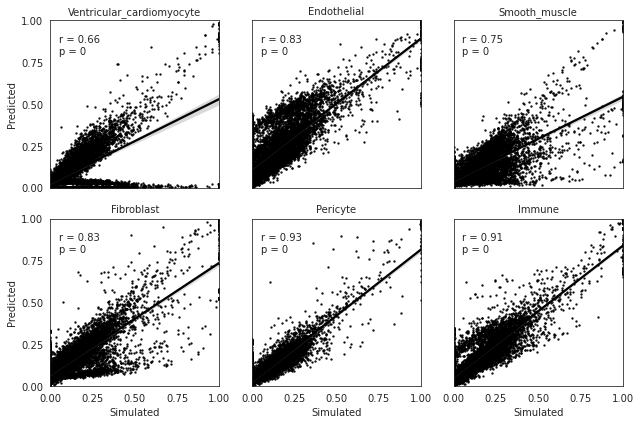

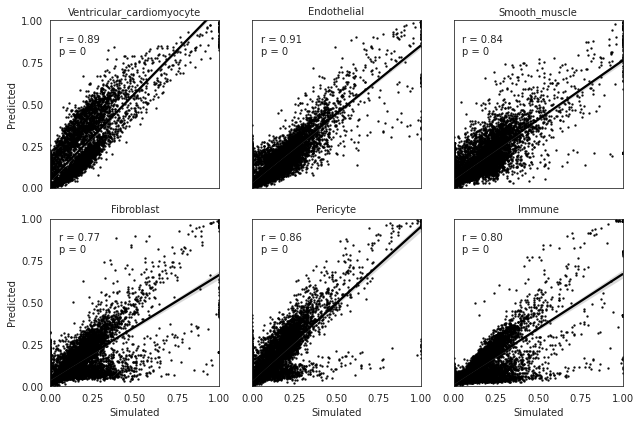

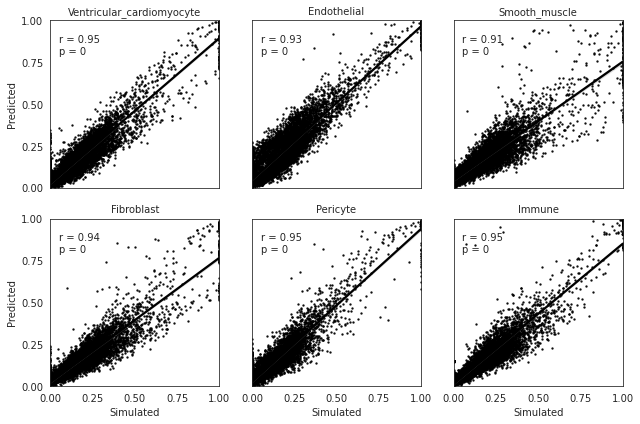

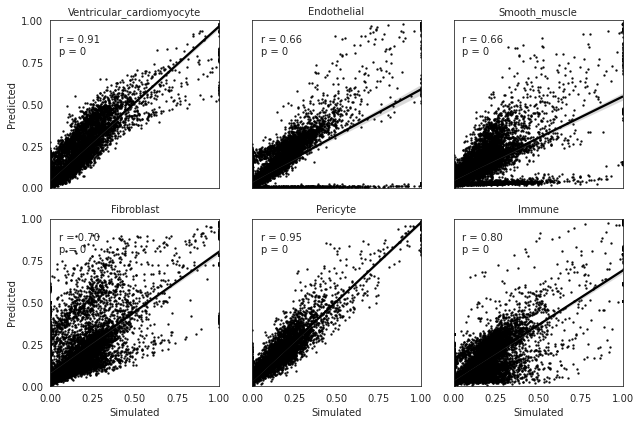

In [151]:
for i in range(5):
    fold = f"fold{i}"
    true = pd.read_csv(os.path.join(dirloc, fold, 'bulk', basename_true), sep='\t')[cell_types]
    predicted = pd.read_csv(os.path.join(dirloc, fold, basename_predicted), sep='\t', index_col=0)[cell_types]

    true = pd.DataFrame(true.stack()).reset_index()
    true = true[['level_1', 0]] 
    true.rename(columns={'level_1': 'Cell', 0: 'Simulated'}, inplace=True)

    predicted = pd.DataFrame(predicted.stack()).reset_index()
    predicted = predicted[['level_1', 0]] 
    predicted.rename(columns={'level_1': 'Cell', 0: 'Predicted'}, inplace=True)

    all(true.Cell.values == predicted.Cell.values)

    true = true[['Simulated']]
    matched = pd.concat([predicted, true], axis=1)
    
    matched_known = matched[~(matched.Cell=='Unknown')]

    g = sns.FacetGrid(matched_known, col="Cell", col_wrap=3, margin_titles=False, despine=False);
    g = g.map(sns.regplot, "Simulated", "Predicted", scatter_kws={'s':2}, color='k');
    g.map_dataframe(annotate)

    g.fig.subplots_adjust(wspace=0, hspace=0)
    g.set_axis_labels("Simulated", "Predicted");
    g.set_titles(col_template="{col_name}");
    g.set(xlim=(0, 1), ylim=(0, 1), xticks=[0, .25, .5, .75, 1], yticks=[0, .25, .5, .75, 1]);
    g.tight_layout();
    
    figname = os.path.join(dirloc, fold, 'simulated_vs_predicted_cell_fractions_pearson.png')
    plt.savefig(figname)
        
    # get the correlation values, CCC and RMS per cell type and also using everything
    correlations[fold] = list(map(lambda x: get_r(matched, x, what='Pearson'), cell_types))
    correlations[fold].append(stats.pearsonr(matched['Simulated'], matched['Predicted'])[0])
 
    cccs[fold] = list(map(lambda x: get_r(matched, x, what='Condordance'), cell_types))
    cccs[fold].append(ccc(matched['Simulated'], matched['Predicted']))
    
    rmss[fold] = list(map(lambda x: get_r(matched, x, what='RMS'), cell_types))
    rmss[fold].append(mean_squared_error(matched['Simulated'], matched['Predicted'], squared=False))
    
    # CCC and RMS per sample across cell types
    rms_ = []
    ccc_ = []
    for sample in range(num_samples):
        df = matched.iloc[sample*num_cells:(sample*num_cells+num_cells),:]
        rms_.append(mean_squared_error(df['Simulated'], df['Predicted'], squared=False))
        ccc_.append(ccc(df['Simulated'], df['Predicted']))
    cccs_per_sample[fold] = ccc_
    rmss_per_sample[fold] = rms_

    

In [155]:
# plot all values

In [164]:
correlations_df = pd.DataFrame.from_dict(correlations)
correlations_df.rename(index={i:c for i,c in enumerate(cols)}, inplace=True)

correlations_long = pd.DataFrame(correlations_df.stack()).reset_index()
correlations_long.rename(columns={'level_0': 'Cell', 'level_1': 'Fold', 0: 'Pearson'}, inplace=True)


Text(0.5, 1.0, 'Correlation per cell type')

<AxesSubplot:title={'center':'Correlation per cell type'}, xlabel='Fold', ylabel='Pearson'>

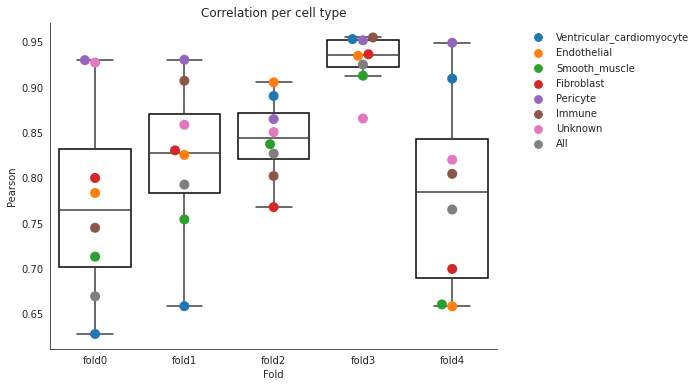

In [196]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(x="Fold", y="Pearson", data=correlations_long, ax=ax, **{'boxprops':{'facecolor':'none', 'edgecolor':'k'}}).set_title("Correlation per cell type");
# sns.swarmplot(x="Fold", y="Pearson", data=correlations_long, color=".25", ax=ax);
sns.swarmplot(x="Fold", y="Pearson", data=correlations_long, palette=palette, hue='Cell', size=10, ax=ax);
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False)
sns.despine();
figname = os.path.join(dirloc, 'all_pearson.png')
plt.savefig(figname, bbox_inches='tight')


In [197]:
cccs_df = pd.DataFrame.from_dict(cccs)
cccs_df.rename(index={i:c for i,c in enumerate(cols)}, inplace=True)

cccs_long = pd.DataFrame(cccs_df.stack()).reset_index()
cccs_long.rename(columns={'level_0': 'Cell', 'level_1': 'Fold', 0: 'Concordance corr. coef.'}, inplace=True)


Text(0.5, 1.0, 'Correlation per cell type')

<AxesSubplot:title={'center':'Correlation per cell type'}, xlabel='Fold', ylabel='Concordance corr. coef.'>

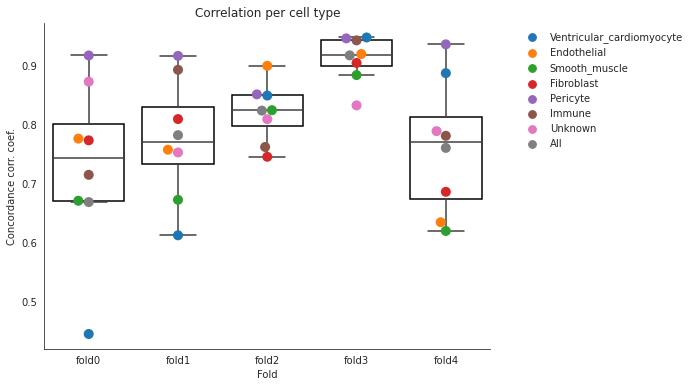

In [198]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(x="Fold", y="Concordance corr. coef.", data=cccs_long, ax=ax, **{'boxprops':{'facecolor':'none', 'edgecolor':'k'}}).set_title("Correlation per cell type");
sns.swarmplot(x="Fold", y="Concordance corr. coef.", data=cccs_long, palette=palette, hue='Cell', size=10, ax=ax);
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False)
sns.despine();
figname = os.path.join(dirloc, 'all_ccc.png')
plt.savefig(figname, bbox_inches='tight')

In [199]:
rmss_df = pd.DataFrame.from_dict(rmss)
rmss_df.rename(index={i:c for i,c in enumerate(cols)}, inplace=True)

rmss_long = pd.DataFrame(rmss_df.stack()).reset_index()
rmss_long.rename(columns={'level_0': 'Cell', 'level_1': 'Fold', 0: 'RMSE'}, inplace=True)


Text(0.5, 1.0, 'RMSE per cell type')

<AxesSubplot:title={'center':'RMSE per cell type'}, xlabel='Fold', ylabel='RMSE'>

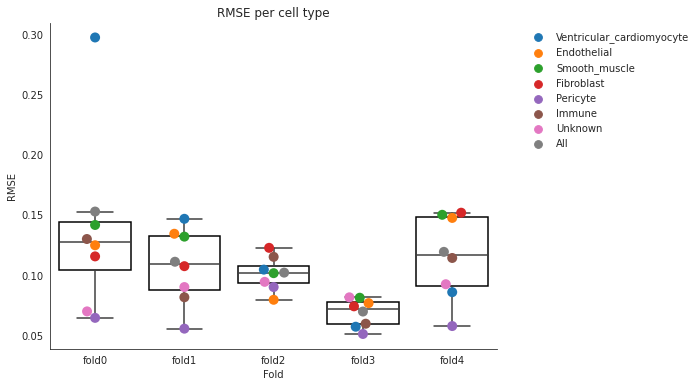

In [200]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(x="Fold", y="RMSE", data=rmss_long, ax=ax, **{'boxprops':{'facecolor':'none', 'edgecolor':'k'}}).set_title("RMSE per cell type");
sns.swarmplot(x="Fold", y="RMSE", data=rmss_long, palette=palette, hue='Cell', size=10, ax=ax);
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False)
sns.despine();
figname = os.path.join(dirloc, 'all_rmse.png')
plt.savefig(figname, bbox_inches='tight')

In [206]:
cccs_per_sample_df = pd.DataFrame.from_dict(cccs_per_sample)

cccs_per_sample_long = pd.DataFrame(cccs_per_sample_df.stack()).reset_index()
cccs_per_sample_long.rename(columns={'level_0': 'Sample', 'level_1': 'Fold', 0: 'Concordance corr. coef.'}, inplace=True)


Text(0.5, 1.0, 'Correlation per sample')

<AxesSubplot:title={'center':'Correlation per sample'}, xlabel='Fold', ylabel='Concordance corr. coef.'>

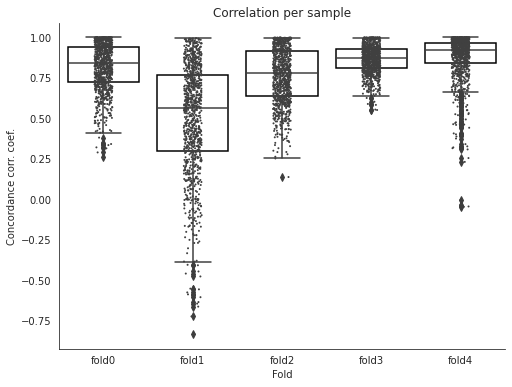

In [211]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(x="Fold", y="Concordance corr. coef.", data=cccs_per_sample_long, ax=ax, **{'boxprops':{'facecolor':'none', 'edgecolor':'k'}}).set_title("Correlation per sample");
sns.stripplot(x="Fold", y="Concordance corr. coef.", data=cccs_per_sample_long, color='.25', size=2, ax=ax);
sns.despine();
figname = os.path.join(dirloc, 'all_ccc_per_sample.png')
plt.savefig(figname, bbox_inches='tight')

In [213]:
rmss_per_sample_df = pd.DataFrame.from_dict(rmss_per_sample)

rmss_per_sample_long = pd.DataFrame(rmss_per_sample_df.stack()).reset_index()
rmss_per_sample_long.rename(columns={'level_0': 'Sample', 'level_1': 'Fold', 0: 'RMSE'}, inplace=True)


Text(0.5, 1.0, 'RMSE per sample')

<AxesSubplot:title={'center':'RMSE per sample'}, xlabel='Fold', ylabel='RMSE'>

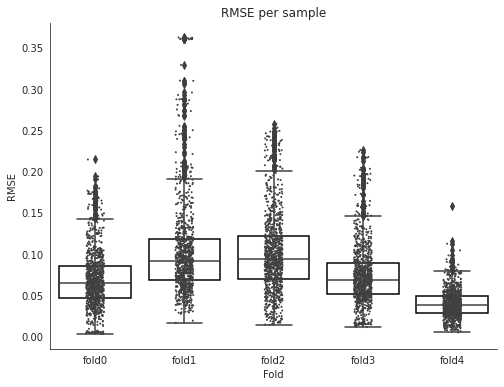

In [214]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.boxplot(x="Fold", y="RMSE", data=rmss_per_sample_long, ax=ax, **{'boxprops':{'facecolor':'none', 'edgecolor':'k'}}).set_title("RMSE per sample");
sns.stripplot(x="Fold", y="RMSE", data=rmss_per_sample_long, color='.25', size=2, ax=ax);
sns.despine();
figname = os.path.join(dirloc, 'all_rmse_per_sample.png')
plt.savefig(figname, bbox_inches='tight')

In [218]:
new_names = {f"fold{i}":f"Pearson{i}" for i in range(5)}
correlations_df.rename(columns=new_names, inplace=True)

new_names = {f"fold{i}":f"CCC{i}" for i in range(5)}
cccs_df.rename(columns=new_names, inplace=True)

new_names = {f"fold{i}":f"RMSE{i}" for i in range(5)}
rmss_df.rename(columns=new_names, inplace=True)

In [225]:
all_scores = pd.concat([correlations_df, cccs_df, rmss_df], axis=1)
def highlight(s):
    for i in range(5):
        if s[f"CCC{i}"] > .9:
            return ['background-color: yellow']*15
        else:
            return ['background-color: white']*15

all_scores.style.apply(highlight, axis=1)

,Pearson0,Pearson1,Pearson2,Pearson3,Pearson4,CCC0,CCC1,CCC2,CCC3,CCC4,RMSE0,RMSE1,RMSE2,RMSE3,RMSE4
Ventricular_cardiomyocyte,0.627822,0.658468,0.890251,0.952999,0.909359,0.444045,0.611723,0.849153,0.947845,0.887232,0.297415,0.146692,0.104468,0.056997,0.085729
Endothelial,0.783280,0.825250,0.905278,0.934607,0.658299,0.775951,0.757129,0.899704,0.919721,0.633883,0.124711,0.134267,0.079401,0.076625,0.147437
Smooth_muscle,0.713041,0.754166,0.837113,0.912568,0.660440,0.670358,0.672000,0.824276,0.883923,0.619063,0.141571,0.131878,0.101516,0.081088,0.150021
Fibroblast,0.799842,0.830244,0.767703,0.936212,0.699506,0.773040,0.809223,0.745143,0.904579,0.685582,0.115458,0.107323,0.122562,0.073951,0.151761
Pericyte,0.929763,0.930185,0.864754,0.951683,0.948942,0.917298,0.916577,0.851152,0.946322,0.936140,0.064375,0.055401,0.089971,0.050970,0.057560
Immune,0.744922,0.907033,0.802015,0.954749,0.804358,0.714450,0.892890,0.761777,0.942919,0.780746,0.129900,0.081476,0.115069,0.059502,0.114148
Unknown,0.927097,0.858510,0.850401,0.865412,0.819902,0.872766,0.752496,0.809058,0.832461,0.788714,0.069736,0.089963,0.094304,0.081426,0.092318
All,0.669333,0.792518,0.826752,0.924844,0.765025,0.668216,0.781839,0.823599,0.917440,0.760219,0.152720,0.111007,0.101962,0.069624,0.119218


In [ ]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

## Notes

Excerpts from Litvinukova *Cells of the adult human heart*:

By contrast, ventricular regions (apex, interventricular septum, left and ventricle) contain 49.2% ventricular cardiomyocytes, 21.2% mural cells, 15.5% FBs, 7.8% ECs and 5.3% immune cells (Fig. 1d, Supplementary Table 2).

The ventricular proportions of ventricular cardiomyocytes and FBs are negatively correlated, whereas pericytes and SMC proportions are positively correlated, indicating a functional organization


In [319]:
cell_composition = pd.read_csv('/prj/MAGE/analysis/deconvolution/scaden/results/MAGNet_cell_composition.txt', sep='\t', index_col=0)

In [320]:
cell_composition.describe()

,Ventricular_cardiomyocyte,Endothelial,Pericyte,Fibroblast,Unknown,Smooth_muscle,Immune
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,0.599640,0.148645,0.018577,0.127468,0.020193,0.047545,0.037930
std,0.111588,0.050922,0.012641,0.050385,0.021379,0.021296,0.024314
min,0.054782,0.044835,0.002596,0.042551,0.002821,0.009877,0.005922
25%,0.541267,0.112873,0.010472,0.093336,0.009584,0.032023,0.022955
50%,0.606479,0.144860,0.015872,0.118660,0.014680,0.043576,0.032261
75%,0.674054,0.177515,0.022317,0.154829,0.021884,0.059448,0.044838
max,0.848878,0.334118,0.075302,0.352476,0.245178,0.141925,0.215648


<AxesSubplot:>

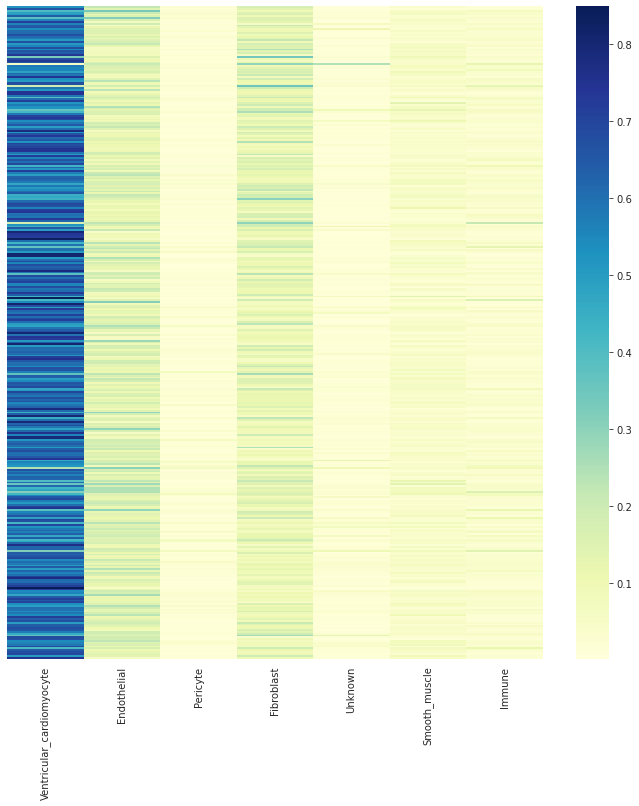

In [260]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
sns.heatmap(cell_composition, cmap="YlGnBu", yticklabels=False, ax=ax)

In [368]:
cell_composition_less = cell_composition[cell_composition['Ventricular_cardiomyocyte']<.4]

<AxesSubplot:>

Text(0.5, 1.0, 'Ventricular CM < .4')

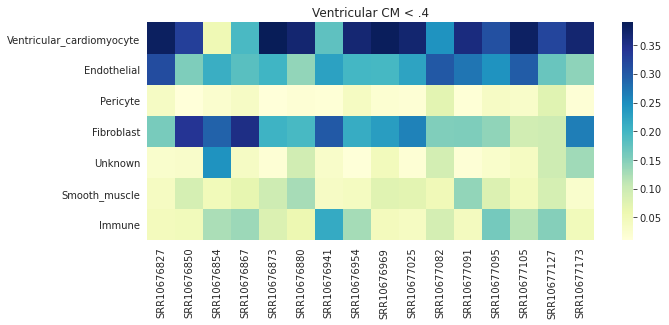

In [381]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.heatmap(cell_composition_less.T, cmap="YlGnBu", yticklabels=True, ax=ax)
ax.set_title('Ventricular CM < .4');
figname = os.path.join('/prj/MAGE/analysis/deconvolution/scaden/results', 'heatmap_LVCMsmall.png')
plt.savefig(figname, bbox_inches='tight')

In [ ]:
# add etiology, etc. to data
import loompy as lp

In [303]:
lf = lp.connect('/prj/MAGE/analysis/data/stringtie/MAGNet_data.loom', mode='r+', validate=False)
col_attrs = lf.ca['CellID', 'Etiology'] # cannot select more than 2 ??
col_attrs = pd.DataFrame(col_attrs)
col_attrs = pd.concat([col_attrs, pd.DataFrame(lf.ca['Sex'])], axis=1)
col_attrs.columns = ['id', 'Etiology', 'Sex']
col_attrs.set_index('id', drop=True, inplace=True)
col_attrs.index.name = None
col_attrs = col_attrs[lf.ca['SampleFlag']==1]
lf.close()

In [329]:
stacked = pd.DataFrame(cell_composition.stack().reset_index())
stacked = stacked.merge(col_attrs, how='left', left_on='level_0', right_index=True)
stacked.rename(columns={'level_1': 'Cell type', 0: 'Proportion'}, inplace=True)
stacked.set_index('level_0', inplace=True, drop=True)
stacked.index.name = None

In [337]:
stacked = stacked[~(stacked['Cell type']=='Unknown')]

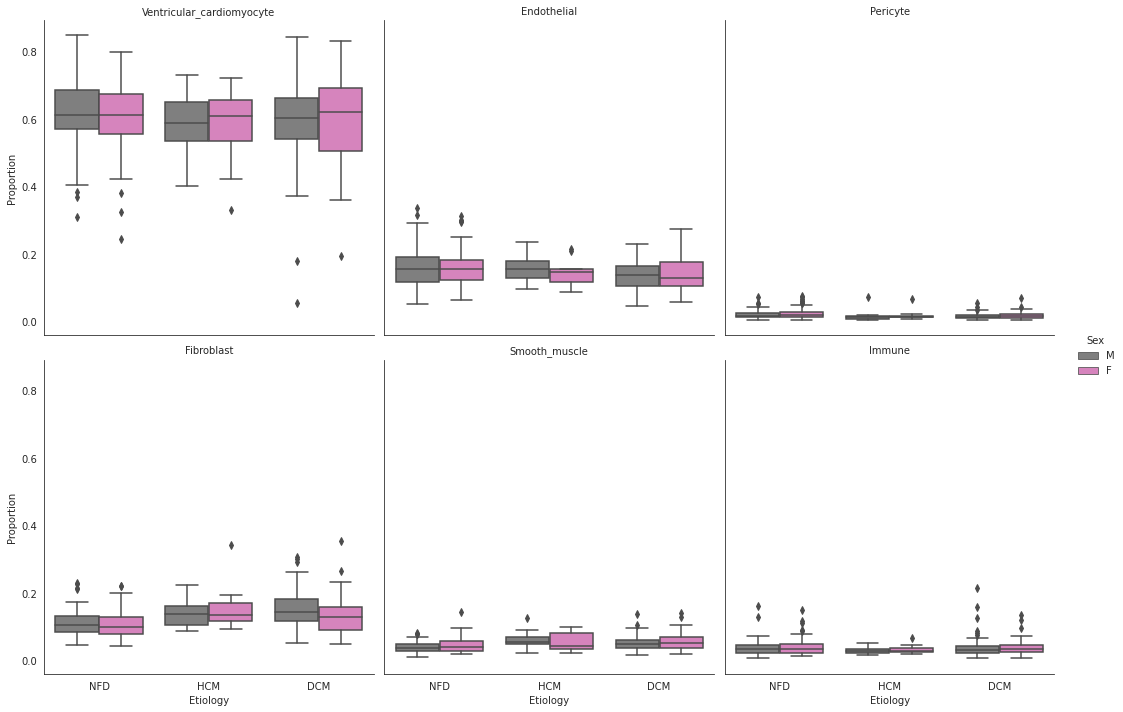

In [356]:
g = sns.catplot(x="Etiology", y="Proportion", hue='Sex', col="Cell type", data=stacked, kind="box",
                col_wrap=3, height=5, aspect=1, palette=palette[6:8][::-1])
g.set_titles(col_template="{col_name}");
g.tight_layout();
figname = os.path.join('/prj/MAGE/analysis/deconvolution/scaden/results', 'predicted_cell_composition_per_etiology_and_sex.png')
plt.savefig(figname)